# Plot Dependency Report

This notebook plots the dependency report.


In [1]:
%reload_ext autoreload
%autoreload 2

[ utils_pickle.py:18 ] INFO: Loding bcc from /Users/szhong/Code/DepSurf/data/output/bcc.pkl
[utils_matplotlib.py:86 ] INFO: Saved figure to /Users/szhong/Code/DepSurf/paper/figs/report.pdf


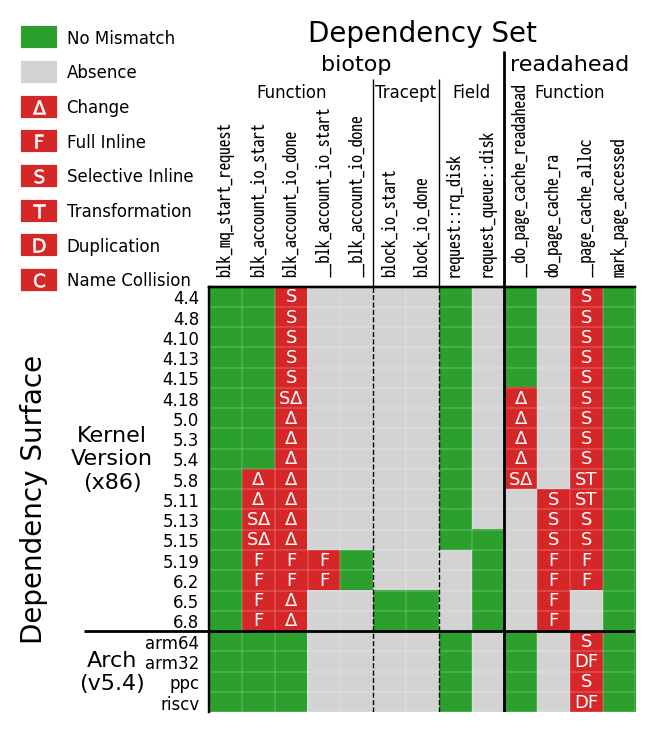

In [11]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.axes import Axes
from matplotlib.lines import Line2D

from depsurf import DepKind, VersionGroup, IssueEnum, Dep, DepReport, IssuesDict
from utils import load_pkl, save_fig, FONT_MONO, ARCH_NAMES

VERTICAL = True


if VERTICAL:
    KEYS = {
        "biotop": [
            DepKind.FUNC("blk_mq_start_request"),
            DepKind.FUNC("blk_account_io_start"),
            DepKind.FUNC("blk_account_io_done"),
            DepKind.FUNC("__blk_account_io_start"),
            DepKind.FUNC("__blk_account_io_done"),
            DepKind.TRACEPOINT("block_io_start"),
            DepKind.TRACEPOINT("block_io_done"),
            DepKind.FIELD("request::rq_disk"),
            DepKind.FIELD("request_queue::disk"),
        ],
        "readahead": [
            DepKind.FUNC("__do_page_cache_readahead"),
            DepKind.FUNC("do_page_cache_ra"),
            DepKind.FUNC("__page_cache_alloc"),
            DepKind.FUNC("mark_page_accessed"),
        ],
    }

    GROUPS = {
        VersionGroup.REGULAR: "Kernel\nVersion\n(x86)",
        VersionGroup.ARCH: "Arch\n(v5.4)",
    }
    SEPS = [
        ("Function", 5),
        ("Tracept", 2),
        ("Field", 2),
        ("Function", 4),
    ]
else:
    KEYS = {
        "biotop": [
            DepKind.FUNC("blk_mq_start_request"),
            DepKind.FUNC("blk_account_io_start"),
            DepKind.FUNC("blk_account_io_done"),
            DepKind.STRUCT("gendisk"),
            DepKind.STRUCT("request"),
            DepKind.FIELD("request::rq_disk"),
        ],
    }
    GROUPS = {
        VersionGroup.REGULAR: "Kernel\nVersion\n(x86)",
    }
    SEPS = [
        ("Function", 3),
        ("Struct", 2),
        ("Field", 1),
    ]

ISSUE_SYMBOLS = {
    IssueEnum.ABSENT: "",
    IssueEnum.CHANGE: r"$\Delta$",
    IssueEnum.SELECTIVE_INLINE: "S",
    IssueEnum.FULL_INLINE: "F",
    IssueEnum.DUPLICATE: "D",
    IssueEnum.COLLISION: "C",
    IssueEnum.TRANSFORMATION: "T",
}

LEGNED = [
    ("No Mismatch", "", "tab:green"),
    ("Absence", "", "lightgray"),
    ("Change", r"$\Delta$", "tab:red"),
    ("Full Inline", r"$\text{F}$", "tab:red"),
    ("Selective Inline", r"$\text{S}$", "tab:red"),
    ("Transformation", r"$\text{T}$", "tab:red"),
    ("Duplication", r"$\text{D}$", "tab:red"),
    ("Name Collision", r"$\text{C}$", "tab:red"),
]

if not VERTICAL:
    LEGNED = LEGNED[0:-3]

data: Dict[str, Dict[Dep, DepReport]] = load_pkl("bcc")


def proc_issues_dict(dep: Dep, issues_dict: IssuesDict) -> IssuesDict:
    result: IssuesDict = {}
    for (group, version), issues in issues_dict.items():
        # For structs, we only care about their existence
        if dep.kind == DepKind.STRUCT:
            if IssueEnum.ABSENT not in issues:
                issues = []
        result[(group, version)] = issues
    return result


reports = {
    dep: proc_issues_dict(dep, data[prog_name][dep].issues_dict)
    for prog_name, deps in KEYS.items()
    for dep in deps
}


fig, ax = plt.subplots(figsize=(2.75, 10) if VERTICAL else (3, 10))
ax: Axes


def get_color(issues: List[IssueEnum]):
    if len(issues) == 0:
        return "tab:green"
    if IssueEnum.ABSENT in issues:
        return "lightgray"
    return "tab:red"


color = np.array(
    [
        [
            colors.to_rgb(get_color(issues))
            for (g, v), issues in report.items()
            if g in GROUPS
        ]
        for report in reports.values()
    ]
)

if VERTICAL:
    color = color.swapaxes(0, 1)
ax.imshow(color, aspect=0.618 if VERTICAL else 1)

xlabels = []
for g in GROUPS:
    for v in g.versions:
        if g == VersionGroup.REGULAR:
            xlabels.append(v.short_version)
        elif g == VersionGroup.ARCH:
            xlabels.append(ARCH_NAMES[v.arch])

ylabels = [d.name for d in reports.keys()]

if VERTICAL:
    xlabels, ylabels = ylabels, xlabels

ax.set_xticks(
    np.arange(len(xlabels)),
    labels=xlabels,
    rotation=90,
    font=FONT_MONO if VERTICAL else None,
    fontsize=8 if VERTICAL else 6,
)
ax.set_yticks(
    np.arange(len(ylabels)),
    labels=ylabels,
    fontsize=6,
)
ax.set_xticks(np.arange(len(xlabels) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(ylabels) + 1) - 0.5, minor=True)


ax.grid(which="minor", color="white", linestyle="-", linewidth=0.1)
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")
ax.spines["top"].set_visible(True)
ax.spines["bottom"].set_visible(False)
ax.tick_params(which="minor", length=0)
ax.tick_params(which="major", length=0)


def plot_secondary_ticks(
    ax: Axes,
    axis_name,
    lengths,
    labels,
    pad,
    rotation=0,
    linewidth=0.5,
    linestyle="--",
    fontsize=8,
):
    val = np.array(list(lengths))
    cum = np.cumsum(val)
    mid = cum - val / 2 - 0.5
    div = np.array([*cum][:-1]) - 0.5

    if VERTICAL:
        axis_name = "y" if axis_name == "x" else "x"

    if axis_name == "x":
        axis = ax.secondary_xaxis("top").xaxis
    else:
        axis = ax.secondary_yaxis("left").yaxis

    # plot labels
    axis.set_ticks(
        mid, labels, rotation=rotation, va="center", ha="center", fontsize=fontsize
    )
    axis.set_tick_params(length=0, pad=pad)

    # plot ticks
    tick_length = pad + (5 if axis_name == "x" else 10)
    axis.set_ticks(div, labels=[], minor=True)
    axis.set_tick_params(length=tick_length, width=linewidth, which="minor")

    axline = ax.axvline if axis_name == "x" else ax.axhline
    for d in div:
        axline(d, color="black", lw=linewidth, linestyle=linestyle)


if VERTICAL:
    plot_secondary_ticks(
        ax,
        "x",
        [len(g) for g in GROUPS],
        GROUPS.values(),
        linewidth=1,
        linestyle="-",
        pad=35 if VERTICAL else 35,
        rotation=0 if VERTICAL else 0,
    )

plot_secondary_ticks(
    ax,
    "y",
    [s[1] for s in SEPS],
    [s[0] for s in SEPS],
    fontsize=6,
    linestyle="--" if VERTICAL else "-",
    pad=70 if VERTICAL else 95,
    rotation=0,
)

if VERTICAL:
    plot_secondary_ticks(
        ax,
        "y",
        [9, 4],
        ["biotop", "readahead"],
        linewidth=1,
        linestyle="-",
        pad=80 if VERTICAL else 115,
        rotation=0 if VERTICAL else 90,
    )


for i, report in enumerate(reports.values()):
    for j, issues in enumerate(report.values()):
        text = "".join([ISSUE_SYMBOLS[e] for e in issues])
        ax.text(
            i if VERTICAL else j,
            j if VERTICAL else i,
            text,
            ha="center",
            va="center",
            color="white",
            fontsize=6.5,
        )


ax.legend(
    handles=[
        Line2D(
            [],
            [],
            linewidth=8,
            color=color,
            marker=marker,
            markerfacecolor="white",
            markeredgecolor="white",
            markeredgewidth=0.2,
            markersize=5,
        )
        for label, marker, color in LEGNED
    ],
    labels=[label for label, _, _ in LEGNED],
    loc="upper left",
    # (x: positive to the right, y: positive to the top)
    bbox_to_anchor=(-0.45, 1.64) if VERTICAL else (-1.25, 1.25),
    ncol=1,
    fontsize=6,
    handlelength=0.8,
    labelspacing=1,
    handletextpad=1.25,
)


if VERTICAL:
    ax.set_xlabel("Dependency Set", fontsize=10, labelpad=15)
    ax.set_ylabel("Dependency Surface", fontsize=10, labelpad=35)
else:
    ax.set_xlabel("Dependency Surface", fontsize=10, labelpad=10)
    ax.set_ylabel("Dependency Set", fontsize=10, labelpad=45)

save_fig(fig, "report")

In [7]:
list(SEPS.keys())

['Function', 'Tracept', 'Field', 'Struct']